<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-modules" data-toc-modified-id="Load-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load modules</a></span></li><li><span><a href="#Some-functions" data-toc-modified-id="Some-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some functions</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Plot-an-example" data-toc-modified-id="Plot-an-example-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot an example</a></span></li><li><span><a href="#Plot-with-weighted-edges" data-toc-modified-id="Plot-with-weighted-edges-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot with weighted edges</a></span></li></ul></li><li><span><a href="#Community-detection" data-toc-modified-id="Community-detection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Community detection</a></span><ul class="toc-item"><li><span><a href="#Plot-with-colours-indicating-communities" data-toc-modified-id="Plot-with-colours-indicating-communities-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plot with colours indicating communities</a></span></li></ul></li></ul></div>

# Community Detection Example

This notebook is adapted from Damhán's `csv_to_nx_graph.py`

Now it makes the final graph prettier and can load 2016 data

## Load modules

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import textwrap
import json
from pprint import pprint

## Some functions

In [2]:
def graph_of_data(df):
    """
    Input: an election dataframe for a constitutency.
    Output: a NetworkX weighted digraph representing the transfers between candidates.
    Does this by filtering the inputted dataframe by count, then extracting the values of transfers using Pandas.

    """
    
    #--Merge these columns, will be labels of the nodes
    df["Name"] = df["Candidate surname"].astype("str") +" " + df["Candidate First Name"].astype("str")
    
    #--Create the DiGraph
    G = nx.DiGraph()
    count_lst = list(df["Count Number"].unique())
    #--There are no transfers on the first count so we will ignore
    count_lst.remove(1)
    #--Filter by count
    for count in count_lst:
        count_df = df[df["Count Number"]==count]
        #--filter by candidates whose votes are transferred
        src_cands = count_df[count_df["Transfers"]<0]
        #--filter by candidates who receive these transfers
        to_cands =count_df[count_df["Transfers"]>0]
        #--get these list of candidates to create the graph below
        src_names = list(src_cands["Name"].values)
        to_names = list(to_cands["Name"].values)

        #--add edge weights as: the amount of votes transferred to a candidate as a proportion of the total votes transferred per count
        src_wgts = list(src_cands["Transfers"].values)
        to_wgts = list(to_cands["Transfers"].values)

            #--if there's more than one src_cand per count, the number of transfers a candidate receives will be
            #--a proportion of this total
        total = np.abs(np.sum(src_wgts))

        wgts = [round(wgt/total, 2) for wgt in to_wgts]
            
        #--Create a weighted edge between each source candidate and each target candidate
        for i in range(len(src_names)):
            for j in range(len(to_names)):
                G.add_edge(src_names[i],to_names[j],weight=wgts[j])
    return G

In [3]:
def plot_G(G, layout="circular"):
    """
    Input: a NetworkX weighted DiGraph.
    Each edge in the graph has a 'weight' attribute created in above function, that is used by NetworkX default method get_edge_attributes().
    Output: a circular graph, labelled with transfers between candidates.
    
    """
    
    plt.figure(figsize=(12, 12))
    
    opts = {"with_labels":True,"node_size":600}
    
    if (layout=="circular"):
        nx.draw_circular(G,**opts)
    else:
        nx.draw(G,**opts)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=edge_labels)
    
    plt.title("Graph of Transfers between Candidates")
    plt.show()

In [4]:
def wrap_label(s, width=10):
    # Wrap at word boundaries; join with newline
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

## Load data

In [5]:
# full_df = pd.read_csv("General_Election_2020_full.csv", encoding="utf-8")
full_df = pd.read_csv("2020-05-27_general-election-2020-countdetails-csv_en.csv", encoding="latin-1")
Year = 2020
#full_df = pd.read_csv("generalelection2016countdetails.csv", encoding="latin-1")
#Year=2016 # used for plots

In [6]:
constituency_list = list(full_df["Constituency Name"].unique())
print(f"There are {len(constituency_list)} constituencies (sp?)")

There are 39 constituencies (sp?)


In [7]:
for k in range(len(constituency_list)):
    print(f"{k:3d} :  {constituency_list[k]:20s}")

  0 :  Carlow-Kilkenny     
  1 :  Cavan-Monaghan      
  2 :  Clare               
  3 :  Cork East           
  4 :  Cork North Central  
  5 :  Cork North West     
  6 :  Cork South Central  
  7 :  Cork South West     
  8 :  Donegal             
  9 :  Dublin Bay North    
 10 :  Dublin Bay South    
 11 :  Dublin Central      
 12 :  Dublin Fingal       
 13 :  Dublin Mid West     
 14 :  Dublin North West   
 15 :  Dublin Rathdown     
 16 :  Dublin South Central
 17 :  Dublin South West   
 18 :  Dublin West         
 19 :  Dun Laoghaire       
 20 :  Galway East         
 21 :  Galway West         
 22 :  Kerry               
 23 :  Kildare North       
 24 :  Kildare South       
 25 :  Laois Offaly        
 26 :  Limerick City       
 27 :  Limerick County     
 28 :  Longford Westmeath  
 29 :  Louth               
 30 :  Mayo                
 31 :  Meath East          
 32 :  Meath West          
 33 :  Roscommon - Galway  
 34 :  Sligo Leitrim       
 35 :  Tipperary    

In [8]:
# 2020: "Galway East" is 29
# 2020: "Galway East" is 20
constituency = constituency_list[20]
constituency_df = full_df.loc[full_df["Constituency Name"]==constituency]
print(constituency)

Galway East


### Plot an example

In [9]:
#constituency_df

/tmp/ipykernel_54051/2753875324.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Name"] = df["Candidate surname"].astype("str") +" " + df["Candidate First Name"].astype("str")


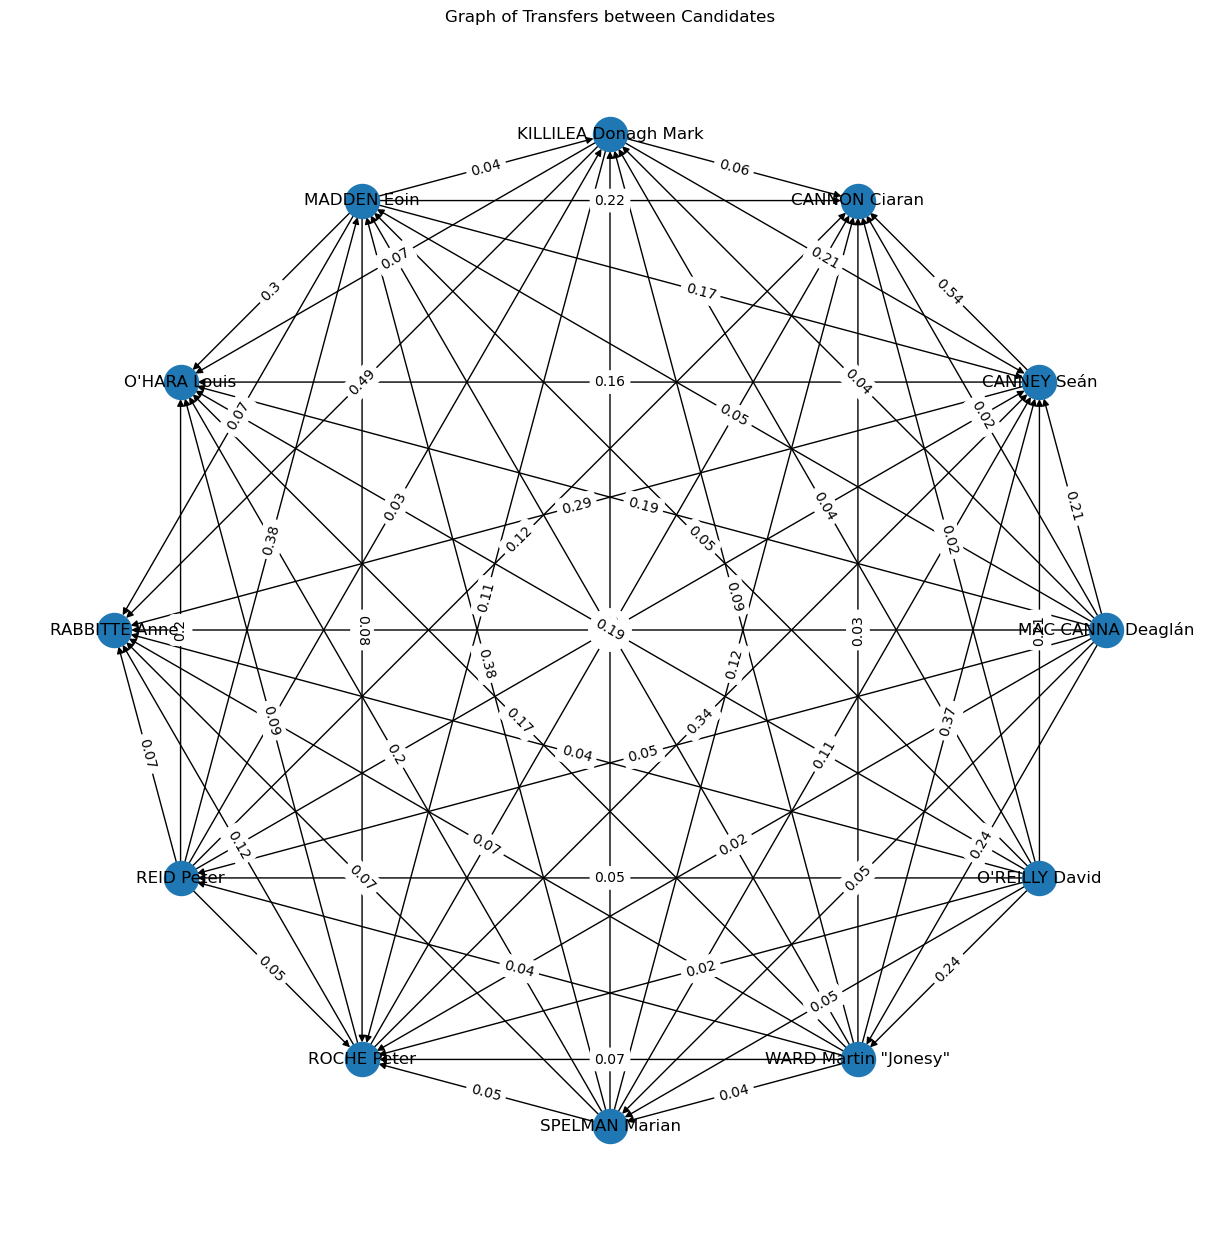

In [10]:
G = graph_of_data(constituency_df)
plot_G(G)

### Plot with weighted edges

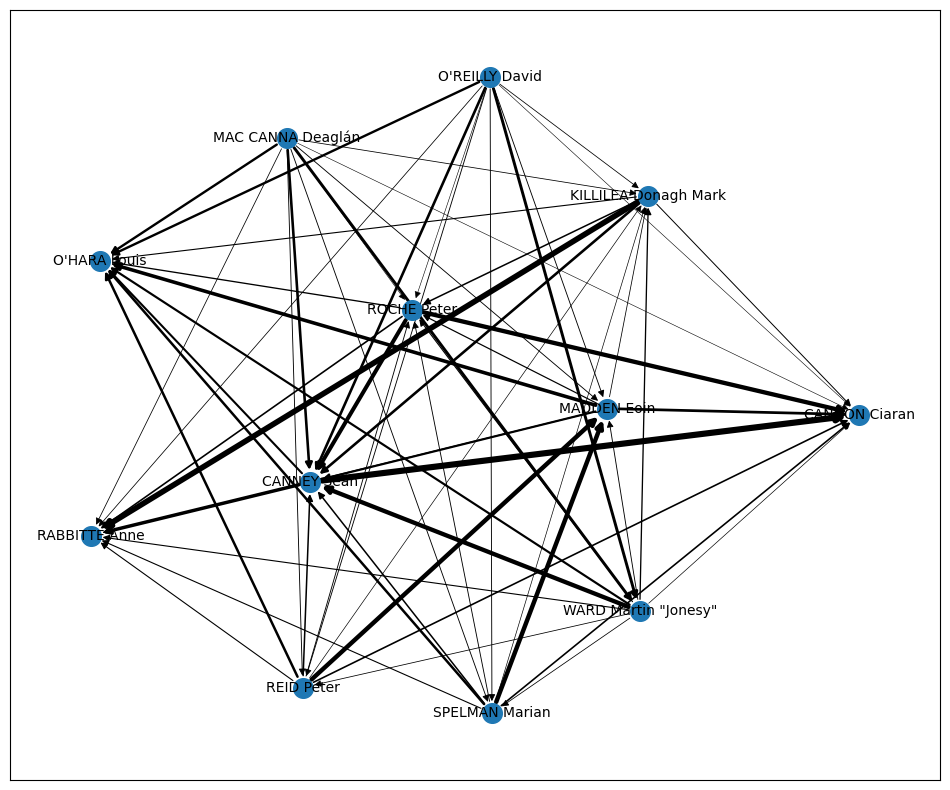

In [11]:
plt.figure(figsize=(12, 10))
pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp") # good for labelled data
label_pos = {n: (x, y-0.04) for n, (x, y) in pos.items()}
weights = nx.get_edge_attributes(G, 'weight')
min_w, max_w = 0.25, 8.0
edge_widths = [min_w + w*(max_w - min_w) for (_, _), w in weights.items()]
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_edges(G, pos, width=edge_widths);
nx.draw_networkx_labels(
    G, label_pos,
    font_size=10,
    horizontalalignment='center'
);

## Community detection

In [12]:
communities = nx.community.louvain_communities(G, seed=12) #set seed for deterministic communities.
print(f"Communities produced by Louvain algorithm for {constituency}:\n")
for c in communities:
    print(f"{c}\n")
    
modularity = nx.community.modularity(G, communities)
print(f"Constituency: {constituency} has modularity {modularity:.4}")

Communities produced by Louvain algorithm for Galway East:

{'MAC CANNA Deaglán', "O'REILLY David", 'WARD Martin "Jonesy"'}

{'CANNEY Seán', 'ROCHE Peter', 'RABBITTE Anne', 'CANNON Ciaran', 'KILLILEA Donagh Mark'}

{'REID Peter', "O'HARA Louis", 'MADDEN Eoin', 'SPELMAN Marian'}

Constituency: Galway East has modularity 0.1955


### Plot with colours indicating communities

In [13]:
community_colours = ["cyan", "yellow", "pink", "orange"]
nodes = list(G.nodes())
node_colors = []

for n in nodes:
    for i, comm in enumerate(communities):
        if n in comm:
            node_colors.append(community_colours[i])
            break

In [14]:
#nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=800, width=edge_widths)

In [15]:


comm_id = {}
for i, comm in enumerate(communities):
    for n in comm:
        comm_id[n] = i

# 2) Build a contracted "community graph" (super-graph)
H = nx.Graph()
H.add_nodes_from(range(len(communities)))  # one node per community

# Add weighted edges between communities based on total inter-community edge weight
for u, v, d in G.edges(data=True):
    cu, cv = comm_id[u], comm_id[v]
    if cu != cv:
        w = d.get('weight', 1.0)
        if H.has_edge(cu, cv):
            H[cu][cv]['weight'] += w
        else:
            H.add_edge(cu, cv, weight=w)

# 3) Lay out community centroids (use a force-directed layout on H)
centroid_pos = nx.circular_layout(H, scale=0.5)  # good spacing for small graphs
#centroid_pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")

# 4) Lay out nodes within each community around its centroid
pos = {}
for i, comm in enumerate(communities):
    # local layout for the community subgraph
    subG = G.subgraph(comm)
    local = nx.circular_layout(subG)  # compact local layout

    # translate local positions to the community centroid
    cx, cy = centroid_pos[i]
    # scale to keep the community tight; tweak 'scale' if you want bigger clusters
    scale = 0.25
    for n, (x, y) in local.items():
        pos[n] = (cx + scale * x, cy + scale * y)

In [16]:
labels = {n: wrap_label(str(n), width=9) for n in G.nodes}
print(labels)

{'MAC CANNA Deaglán': 'MAC CANNA\nDeaglán', 'CANNEY Seán': 'CANNEY\nSeán', 'CANNON Ciaran': 'CANNON\nCiaran', 'KILLILEA Donagh Mark': 'KILLILEA\nDonagh\nMark', 'MADDEN Eoin': 'MADDEN\nEoin', "O'HARA Louis": "O'HARA\nLouis", 'RABBITTE Anne': 'RABBITTE\nAnne', 'REID Peter': 'REID\nPeter', 'ROCHE Peter': 'ROCHE\nPeter', 'SPELMAN Marian': 'SPELMAN\nMarian', 'WARD Martin "Jonesy"': 'WARD\nMartin\n"Jonesy"', "O'REILLY David": "O'REILLY\nDavid"}


Writing to Galway-East-GE2020.png


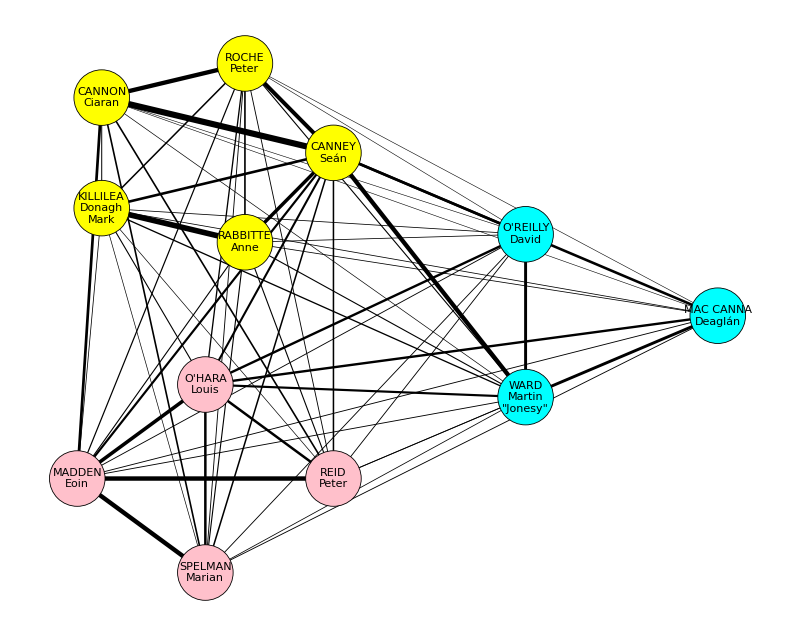

In [17]:
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1600, edgecolors='k', linewidths=0.6)
nx.draw_networkx_edges(G, pos, width=edge_widths)
nx.draw_networkx_labels(G, pos, font_size=8, labels=labels)
plt.axis('off')
#plt.tight_layout()
FileName = f"{constituency.replace(' ', '-')}-GE{Year}.png"
print(f"Writing to {FileName}")
plt.savefig(FileName, dpi=300, bbox_inches='tight')
plt.show()